This notebook is heavily inspired/copypastaed from https://stackoverflow.com/questions/50829874/how-to-find-table-like-structure-in-image

In [1]:
# core
import cv2
import matplotlib.pyplot as plt
# helpers
from pathlib import Path
import os

# This only works if there's only one table on a page
# Important parameters:
#  - morph_size
#  - min_text_height_limit
#  - max_text_height_limit
#  - cell_threshold
#  - min_columns

In [2]:
def pre_process_image(img, save_in_file, threshold='gauss', morph_size=(3, 3), iterations=5):
    # get rid of the color
    pre = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # smooth image
    pre = cv2.GaussianBlur(pre, (3,3), 0)
    # threshold
    if threshold == 'gauss':
        pre = cv2.adaptiveThreshold(pre, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY, 11, 5)
    elif threshold == 'otsu':
        # Otsu threshold
        pre = cv2.threshold(pre, 250, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # dilate the text to make it solid spot
    cpy = pre.copy()
    struct = cv2.getStructuringElement(cv2.MORPH_RECT, morph_size)
    cpy = cv2.dilate(~cpy, struct, anchor=(-1, -1), iterations=iterations)
    pre = ~cpy

    if save_in_file is not None:
        cv2.imwrite(save_in_file, pre)
    return pre

In [3]:
def find_text_boxes(pre, min_text_height_limit=6, max_text_height_limit=40):
    # Looking for the text spots contours
    contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Getting the texts bounding boxes based on the text size assumptions
    boxes = []
    for contour in contours:
        box = cv2.boundingRect(contour)
        h = box[3]

        if min_text_height_limit < h < max_text_height_limit:
            boxes.append(box)

    return boxes

In [4]:
def find_table_in_boxes(boxes, cell_threshold=10, min_columns=2):
    rows = {}
    cols = {}

    # Clustering the bounding boxes by their positions
    for box in boxes:
        (x, y, w, h) = box
        col_key = x // cell_threshold
        row_key = y // cell_threshold
        cols[row_key] = [box] if col_key not in cols else cols[col_key] + [box]
        rows[row_key] = [box] if row_key not in rows else rows[row_key] + [box]

    # Filtering out the clusters having less than 2 cols
    table_cells = list(filter(lambda r: len(r) >= min_columns, rows.values()))
    # Sorting the row cells by x coord
    table_cells = [list(sorted(tb)) for tb in table_cells]
    # Sorting rows by the y coord
    table_cells = list(sorted(table_cells, key=lambda r: r[0][1]))

    return table_cells

In [5]:
def build_lines(table_cells):
    if table_cells is None or len(table_cells) <= 0:
        return [], []

    max_last_col_width_row = max(table_cells, key=lambda b: b[-1][2])
    max_x = max_last_col_width_row[-1][0] + max_last_col_width_row[-1][2]
    
    min_x = max(table_cells, key=lambda b: b[-1][2])[-1][0]

    max_last_row_height_box = max(table_cells[-1], key=lambda b: b[3])
    max_y = max_last_row_height_box[1] + max_last_row_height_box[3]

    hor_lines = []
    ver_lines = []

    for box in table_cells:
        x = box[0][0]
        y = box[0][1]
        hor_lines.append((min_x, y, max_x, y))

    for box in table_cells[0]:
        x = box[0]
        y = box[1]
        ver_lines.append((min_x, y, min_x, max_y))

    (x, y, w, h) = table_cells[0][-1]
    ver_lines.append((max_x, y, max_x, max_y))
    (x, y, w, h) = table_cells[0][0]
    hor_lines.append((min_x, max_y, max_x, max_y))

    return hor_lines, ver_lines

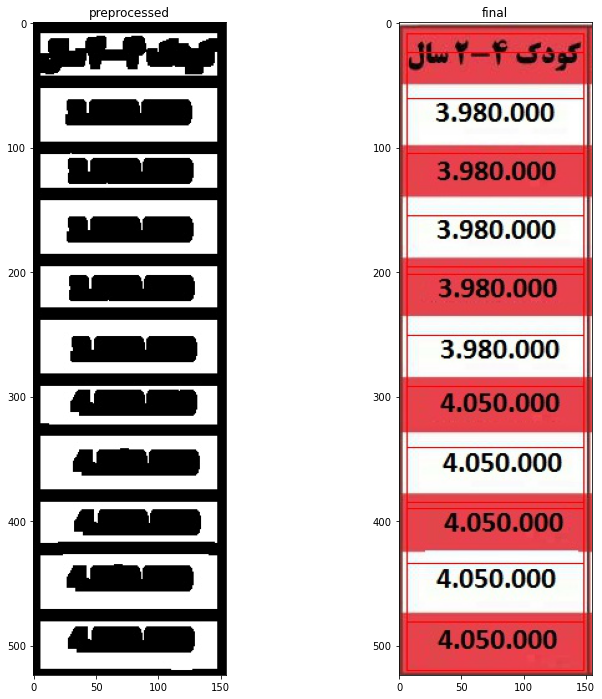

In [6]:
in_file = Path('sample/orig/01-col-with-border.png').as_posix()
pre_file = Path('notebooks/03-pre.jpg').as_posix()
out_file = Path('notebooks/03-final.jpg').as_posix()

img = cv2.imread(in_file)

pre_processed = pre_process_image(img, pre_file, threshold='gauss', morph_size=(3, 3), iterations=3)
text_boxes = find_text_boxes(pre_processed, min_text_height_limit=6, max_text_height_limit=40)
cells = find_table_in_boxes(text_boxes, cell_threshold=10, min_columns=1)
hor_lines, ver_lines = build_lines(cells)

# Visualize the result
vis = img.copy()

# for box in text_boxes:
#     (x, y, w, h) = box
#     cv2.rectangle(vis, (x, y), (x + w - 2, y + h - 2), (0, 255, 0), 1)

for line in hor_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

for line in ver_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

cv2.imwrite(out_file, vis)

# show pre and output images side by side
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(plt.imread(pre_file), cmap='gray')
ax.set_title('preprocessed')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(plt.imread(out_file), cmap='gray')
ax.set_title('final')
plt.show()

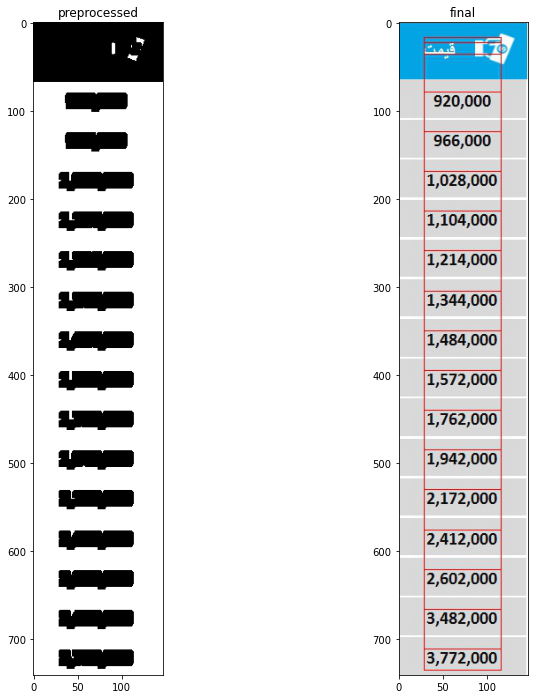

In [10]:
in_file = Path('sample/orig/03-col-wo-border.png').as_posix()
pre_file = Path('notebooks/03-pre.jpg').as_posix()
out_file = Path('notebooks/03-final.jpg').as_posix()

img = cv2.imread(in_file)

pre_processed = pre_process_image(img, pre_file, threshold='otsu', morph_size=(3, 3), iterations=3)
text_boxes = find_text_boxes(pre_processed, min_text_height_limit=6, max_text_height_limit=40)
cells = find_table_in_boxes(text_boxes, cell_threshold=10, min_columns=1)
hor_lines, ver_lines = build_lines(cells)

# Visualize the result
vis = img.copy()

# for box in text_boxes:
#     (x, y, w, h) = box
#     cv2.rectangle(vis, (x, y), (x + w - 2, y + h - 2), (0, 255, 0), 1)

for line in hor_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

for line in ver_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

cv2.imwrite(out_file, vis)

# show pre and output images side by side
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(plt.imread(pre_file), cmap='gray')
ax.set_title('preprocessed')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(plt.imread(out_file), cmap='gray')
ax.set_title('final')
plt.show()

In [ ]:
in_file = Path('sample/orig/05-col-wo-border.png').as_posix()
pre_file = Path('notebooks/03-pre.jpg').as_posix()
out_file = Path('notebooks/03-final.jpg').as_posix()

img = cv2.imread(in_file)

pre_processed = pre_process_image(img, pre_file, threshold='otsu', morph_size=(3, 3), iterations=3)
text_boxes = find_text_boxes(pre_processed, min_text_height_limit=6, max_text_height_limit=40)
cells = find_table_in_boxes(text_boxes, cell_threshold=10, min_columns=1)
hor_lines, ver_lines = build_lines(cells)

# Visualize the result
vis = img.copy()

# for box in text_boxes:
#     (x, y, w, h) = box
#     cv2.rectangle(vis, (x, y), (x + w - 2, y + h - 2), (0, 255, 0), 1)

for line in hor_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

for line in ver_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

cv2.imwrite(out_file, vis)

# show pre and output images side by side
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(plt.imread(pre_file), cmap='gray')
ax.set_title('preprocessed')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(plt.imread(out_file), cmap='gray')
ax.set_title('final')
plt.show()